In [2]:
# modual imports
import sympy as sy
import sympy.vector as vc
from sympy.utilities.lambdify import lambdastr
sy.init_printing(use_latex=True) # set ipython to use latex
import numpy as np
import copy as cp 

from my_animate_v2 import multi_animate, percent_print
from IPython.display import HTML, display

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# matplotlib preferences
# mpl.rcdefaults()  # reset
plt.rc('axes', titlesize=20, labelsize=15)
plt.rc('axes.formatter', limits=[-4, 4])
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('lines', linewidth=1, markersize=5)
plt.rc('figure', figsize=(5, 5))
# print(plt.rcParams) # all parameters

## 1.3.2 MMS

### Manufactured solution
I need to manufacture a solution to test the solver, of which I am free to vary my guesses for $T, C_p, k, \rho$ provided they exercise the solver fully. The functions used in 1.3.1 exercises are a good starting point, but will need simplifying as they are in 3D.

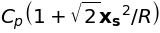

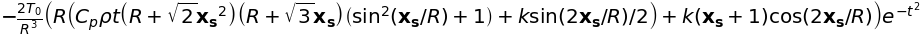

In [117]:
# declare coordinate system and symbols
s = vc.CoordSys3D('s')
t = sy.Symbol('t')
k_, r_, Cp_, T_, R_ = sy.symbols(['k', 'rho', 'C_p', 'T_0', 'R'])  # constants

# Manufactured solution equations
T_f = T_ * (1 + sy.sin(s.x/R_)**2) * sy.exp(-t**2)
k_f = k_ * (1 + s.x)/R_
r_f = r_ * (1 + sy.sqrt(3) * s.x/R_)
Cp_f = Cp_ * (1 + sy.sqrt(2) * s.x**2/R_)
dk_f = sy.diff(k_f, s.x)

# print these equations
for eqn in (T_f, k_f, r_f, Cp_f, dk_f):
    display(eqn)

# find source term
g_f = r_f * Cp_f * sy.diff(T_f, t) - vc.divergence(k_f * vc.gradient(T_f))
g_f = sy.simplify(g_f)
display(g_f)

I have simplified each term by removing any $y,z$ components and also removed $t_0$ in the exponential so I am free to begin from $t=0$ it. Note that I have removed $y,z$ components in a way that is inconsistent with the previous 3D equations, but I am free to do this as these equations still vary enough to fully test the solver. I have also found dk/dx as this will be required later.

Caution needs to be taken when it comes to the x domain as these equations are only reasonable for positive x values (negative densities, etc are meaningless).

To obtain these functions in python form I will use sympys lambdastr function and copy string into my solver. The reason for this over lambdify is here I can ensure the correct constants are being used from the variable scope.

In [118]:
# create the lambda functions in string
x = sy.Symbol('x')
for eqn in [T_f, k_f, r_f, Cp_f, dk_f, g_f]:
    eqn = eqn.subs(s.x, x)
    print(lambdastr((x, t), eqn) + ',')

lambda x,t: (T_0*(sin(x/R)**2 + 1)*exp(-t**2)),
lambda x,t: (k*(x + 1)/R),
lambda x,t: (rho*(1 + sqrt(3)*x/R)),
lambda x,t: (C_p*(1 + sqrt(2)*x**2/R)),
lambda x,t: (k/R),
lambda x,t: (-2*T_0*(R*(C_p*rho*t*(R + sqrt(2)*x**2)*(R + sqrt(3)*x)*(sin(x/R)**2 + 1) + k*sin(2*x/R)/2) + k*(x + 1)*cos(2*x/R))*exp(-t**2)/R**3),


### Solver theory
We are requested to make a 1D solver of the heat equation, with second order accuracy. Due to the time dependence of the source term any implicit scheme will be very complex to solve, so only explicit schemes are reasonable here. To obtain second order in space for both the first and second derivatives required a central scheme would be effective.

For a second order in time some kind of predicator corrector method; Runge-Kutta-2 is the natural choice. But to be safe I will also make the simpler Forward Euler (FT) solver too for debugging purposes.

Rearranging the heat equation spacial and time derivatives we get:

$$
\frac{1}{\rho C_p} \Big( \frac{\partial}{\partial x} \big( k \frac{\partial T}{\partial x} \big) + g \Big) = \frac{\partial T}{\partial t}
$$

Then we can discretize the spacial derivatives on the left hand side via central difference, but first apply the product rule to reduce the chance of a mistake:

$$\frac{\partial k}{\partial x} \frac{\partial T}{\partial x} + k \frac{\partial^2 T}{\partial x^2} = \frac{(k_{n+1} - k_{n-1}) (T_{n+1} - T_{n-1})}{4dx^2} + k_n \frac{T_{n+1} - 2T_n + T_{n-1}}{dx^2}$$

where dx is a our uniform spacial discretization. Now applying RK2 to the right hand side we get:

$$T^*_n = T_n^t + \delta t f(t_n, T_n^t)$$
$$T_n^{t+dt} = T_n^t + \delta t f(t_n + \frac{\delta t}{2}, T^*)$$

where $f$ is the left hand side of the heat equation above and dt is our time step. 

### Initial and boundary conditions
Unlike the solver in lecture 11 I am not writing a steady state solver, so the initial condition must agree with the expected one at the initial time, hence the expect solution will be used to setup the problem.

For the boundaries we are requested to use Dirichlet boundary conditions (i.e. fix the value of $T$ at the boundaries). The above manufactured solution is time-varying everywhere so I need to recalculate the boundary values at every time step using the known solution so as to mimic the expected solutions behaviour outside the boundaries.

In [37]:
class heat_solver():
    def __init__(self, t_bounds, x_bounds, Nt, Nx):
        
        # store the system parameters
        self.t0, self.dt = t_bounds
        self.x0, self.xf = x_bounds
        self.Nt, self.Nx = Nt+1, Nx+1
                
        # set the spatial grid and time
        self.x = np.linspace(*x_bounds, self.Nx)
        self.times = np.linspace(*t_bounds, self.Nt)
        self.t = self.t0
        
        # find dx and dt (done like this to ensure dx is multiple of x domian)
        self.dt = self.times[1] - self.times[0]
        self.dx = self.x[1] - self.x[0]
        print('dt = ', self.dt, '\ndx = ', self.dx)
        
        # setup empty solution arrays
        self.T_cur = np.empty(self.Nx)
        self.T_tmp = np.empty(self.Nx)  # for storing rk2 guess step
        self.f_val = np.empty(self.Nx)  # for storing LHS of the equation
    
    def create_functions(self, T_0, k, R, rho, C_p):
        "functions generated by sympy"
        # define locally the names as sympy prints them
        from numpy import sin, cos, exp, sqrt, pi
        
        funcs = [lambda x,t: (T_0*(sin(x/R)**2 + 1)*exp(-t**2)),
                lambda x,t: (k*(x + 1)/R),
                lambda x,t: (rho*(1 + sqrt(3)*x/R)),
                lambda x,t: (C_p*(1 + sqrt(2)*x**2/R)),
                lambda x,t: (k/R),
                lambda x,t: (-2*T_0*(R*(C_p*rho*t*(R + sqrt(2)*x**2)*(R + sqrt(3)*x)*(sin(x/R)**2 + 1) + k*sin(2*x/R)/2) + k*(x + 1)*cos(2*x/R))*exp(-t**2)/R**3),
        ]
        # sympy generated functions
        self.T_exact, self.k_func, self.rho_func, self.Cp_func, self.dk_func, self.g = funcs

        # calculate values at grid points as they are constant
        self.k = self.k_func(self.x, self.t)
        self.rho = self.rho_func(self.x, self.t)
        self.Cp = self.Cp_func(self.x, self.t)
        self.dk = np.array([self.dk_func(x, self.t) for x in self.x])
        
        # set the initial conditions
        self.T_cur = self.T_exact(self.x, self.t0)

    def LHS(self, t, n, T):
        g = self.g(self.x[n], t)
        tmp1 = self.dk[n] * (T[n+1] - T[n-1]) / (2*self.dx)
        tmp2 = self.k[n] * (T[n+1] - 2 * T[n] + T[n-1]) / self.dx**2
        return (g + tmp1 + tmp2) / (self.rho[n] * self.Cp[n])

    def RK_step(self):
        # find the derivative for guess step
        for n, x in enumerate(self.x):
            if n != 0 and n != self.Nx-1: # not the end nodes
                self.f_val[n] = self.LHS(self.t, n, self.T_cur)

        # take the guess step and set the boundaries
        self.T_tmp = self.T_cur + self.dt * self.f_val
        self.T_tmp[0] = self.T_exact(self.x0, self.t + self.dt)
        self.T_tmp[-1] = self.T_exact(self.xf, self.t + self.dt)
    
        # find the derivative for the actual step
        for n, x in enumerate(self.x):
            if n != 0 and n != self.Nx-1: # not the end nodes
                self.f_val[n] = self.LHS(self.t + self.dt/2, n, self.T_tmp)

        # find new T value
        self.T_cur = self.T_cur + self.dt * self.f_val
        self.T_cur[0] = self.T_exact(self.x0, self.t + self.dt)
        self.T_cur[-1] = self.T_exact(self.xf, self.t + self.dt)
        
        # advance time
        self.t += self.dt
        
    def FT_step(self):
        "forward time step"
        
        # find the derivative for the step
        for n, x in enumerate(self.x):
            if n != 0 and n != self.Nx-1: # not the end nodes
                self.f_val[n] = self.LHS(self.t, n, self.T_cur)
        
        # make the step and set the boundaries
        self.T_cur[1:-1] = self.T_cur[1:-1] + self.dt * self.f_val[1:-1]
        self.T_cur[0] = self.T_exact(self.x[0], self.t + self.dt)
        self.T_cur[-1] = self.T_exact(self.x[-1], self.t + self.dt)
        
        # advance time
        self.t += self.dt

    def solve(self, save_int=10, method='FT'):
        
        # check the functions have been created
        assert 'g' in vars(self), 'must run create_functions first'
        
        # pick the method wanted
        if method=='FT':
            step_func = self.FT_step
        elif method=='RK2':
            step_func = self.RK_step
        
        # create the result stores
        if save_int is not None:
            self.store_num = np.empty((int(self.Nt/save_int), self.Nx))
            self.store_exact = self.store_num.copy()
            self.store_time = np.empty(int(self.Nt/save_int))
        
        # iterate over times
        for i in range(self.Nt-1):
            step_func()
            percent_print(i, self.Nt)
            if save_int is not None and i % save_int == 0:
                j = int(i/save_int)
                self.store_num[j, :] = self.T_cur.copy()
                self.store_exact[j, :] = self.T_exact(self.x, self.t)
                self.store_time[j] = self.t  # save current time
        print('\nFinal state reached')
        return
        
    def plot(self, ax=None, act=True, exact=False):
        # set up the axis
        if ax is None:
            fig, ax = plt.subplots()
            ax.set(title='System at (t=%.4f)'%self.t, xlabel='x', ylabel='T')

        # plot the state of the system at this time step
        if act is True:
            ax.plot(self.x, self.T_cur, '-o', label='numeric')

        # plot the expected solution at this time step
        if exact is True:
            N = int(self.Nx/10)
            x_tmp = self.x
            T_exact = self.T_exact(x_tmp, self.t)
            ax.plot(x_tmp, T_exact, '-', label='expected')
        
        ax.legend()
        plt.show()
        
    def plot_deriv(self, ax=None):
        "plot the time for analytics and debugging"
        # set up the axis
        if ax is None:
            fig, ax = plt.subplots()
            ax.set(title='derivative of system', xlabel='x', ylabel='T')
        derivs = [self.LHS(self.t, n, self.T_cur) for n in range(1, self.Nx-1)]
        ax.plot(self.x[1:-1], derivs)
        plt.show()
        
    def error(self):
        "find the rms error at this time step"
        analtical = self.T_exact(self.x, self.t)
        diff = self.T_cur - analtical
        return np.sqrt(sum(diff**2) / self.Nx)


A few things to note about this solver:
- it is class based to store all the simulation data in one object
- it is not optimised as run time is not a factor here
- solve loops over the various stepping methods, though the system can be advance manually by
- to ensure finishing at the correct time and a uniform grid the number of nodes and steps are given rather than dx, dt
- one needs to call create_functions after initialization to give the physical constants

### Choice of constants
For this model I will use values for $\rho_0$, etc that are similar to the known values for air with a typical hot temperature to ensure I am within realistic orders of magnitude.
$$C_p \approx 1000 J/kg deg$$
$$\rho_0 \approx 1.25 kg/m^3$$
$$T_0 \approx 50 deg$$
$$k \approx 2\times10^{-5} m^2/s$$

Before testing the convergence with MMS I will test FT for a sample scenario.

dt =  0.002 
dx =  0.031415926535897934


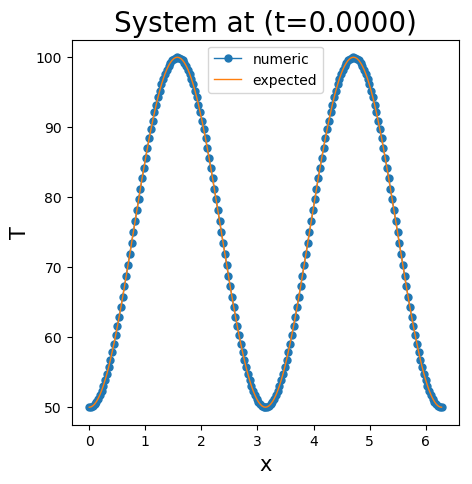

In [127]:
# set up a the system
system = heat_solver([0., 3.], [0., 2*np.pi], 1500, 200)
system.create_functions(50, 2e-5, 1, 1.25, 1000)
system.plot(exact=True)

In [128]:
# solve the system with Forward in time
system.solve(save_int=10, method='FT')

Progress |##################################################|
Final state reached


In [129]:
# use my fancy plotting class thingy
ani_class = multi_animate([system.store_num, system.store_exact],
                          system.x, times=np.round(system.store_time, 2),
                          labels=['Forward', 'expected'])
ani_class.ylims = [-5, 100]  # set the y limits
ani_class.html = True  # tell the function to use a html wrapper
ani_class.frame_skip = 1
ani_class.titles = ['dx=%.4f, dt=%.4f' % (system.dx, system.dt),
                    'x', 'T(x, t)']
ani_class.fmts = ['b-.', 'r--', 'g:']
ani_class.figsize = [6, 6]
ani_class.animate()

The solution appears to be good, however if one solves for longer then zooms in about zero some poor behaviour is seen:

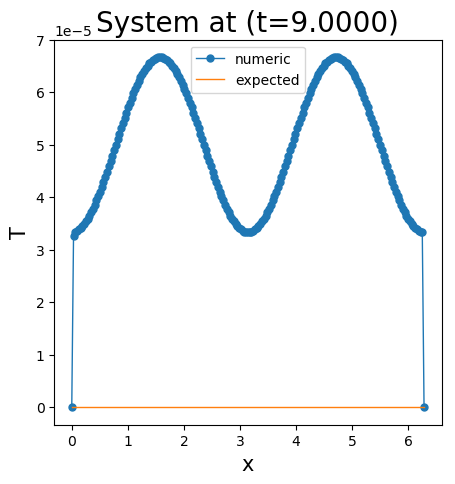

In [151]:
# plot near zero for final state
for _ in range(3000):
    system.FT_step()
system.plot(exact=True)

However the solution does continue to tend to the steady state of zero very slowly. This is likely due to numerical errors being trapped in the solution as they can only leave via the edges, though it could be evidence of a small underlying bug. The magnitude of this affect is small however, so can be accepted for now.

Also when playing with parameters I noticed a stability issue with choice of dt, dx.
````
    system = heat_solver([0., 1.], [0., 2*np.pi], 400, 200) # works
    system = heat_solver([0., 1.], [0., 2*np.pi], 200, 200) # does not
````
The analysis of this is beyond this coursework so I will just trial and error different inputs to get stable simulations. Note I also tried a range of x limits and in the end chose to use $2 \pi$ so that two peaks were analysed with one edge a boundary and the other not.

Now I will try to convergence analysis the FT method in time, with the rms error taken at $t=1$ as the solution is significantly different by this time whilst still not requiring too much computation.

In [131]:
# time convergence FT
Nts = np.array([400 * n for n in range(1, 8)])
t_errors_ft = np.empty(Nts.size)

for i,Nt in enumerate(Nts):
    system_ft = heat_solver([0., 1.], [0., 2*np.pi], Nt, 200)
    system_ft.create_functions(50, 0.2, 1, 1.25, 1)
    
    system_ft.solve(save_int=None, method='FT')
    t_errors_ft[i] = system_ft.error()
    print('error=', system_ft.error(), '\n')

dt =  0.0025 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.06940074536559027 

dt =  0.00125 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.03465948912772599 

dt =  0.0008333333333333334 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.023092542635104265 

dt =  0.000625 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.017312379735035004 

dt =  0.0005 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.013845843807512482 

dt =  0.0004166666666666667 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.011535819834065462 

dt =  0.00035714285714285714 
dx =  0.0314159265358

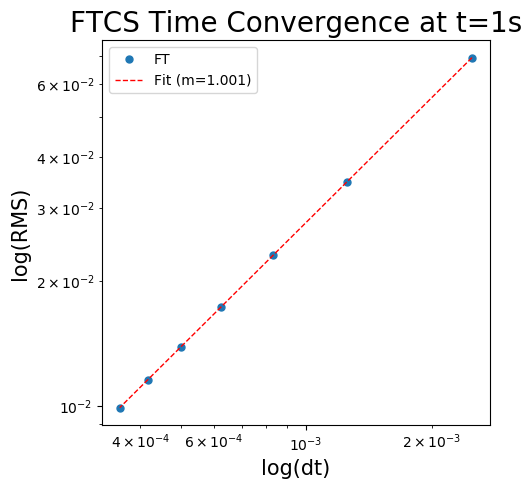

In [137]:
# plot the errors
fig, ax = plt.subplots()
dts = (1-0)/Nts
ax.loglog(dts, t_errors_ft, 'o', label='FT')

# plot the linear fits
log_dts = np.log10(dts)
ft_params = np.polyfit(log_dts[:], np.log10(t_errors_ft)[:], 1)
ax.loglog(dts,10**ft_params[1] * dts**ft_params[0], 'r--', label='Fit (m=%.3f)'%ft_params[0])

ax.set(title='FTCS Time Convergence (t=1s)', xlabel='log(dt)', ylabel='log(RMS)')
ax.legend()
plt.show()

One expects Forward Euler in time to be first order and we pretty much bang on 1st order hear :). This indicates by MMS that my solver is working with best possible error for this method, which is a good start to verifying my FT code.

Now I will try this same time convergence with the RK2 method.

In [144]:
# time convergence FT
Nts = np.array([400 * n for n in range(2, 8)])
t_errors_rk = np.empty(Nts.size)

for i,Nt in enumerate(Nts):
    system_rk = heat_solver([0., 1.], [0., 2*np.pi], Nt, 200)
    system_rk.create_functions(50, 0.2, 1, 1.25, 1)
    
    system_rk.solve(save_int=None, method='RK2')
    t_errors_rk[i] = system_rk.error()
    print('error=', system_rk.error(), '\n')

dt =  0.00125 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.0013337411565960324 

dt =  0.0008333333333333334 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.0010670610392791492 

dt =  0.000625 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.0009341305746223766 

dt =  0.0005 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.0008545493257708591 

dt =  0.0004166666666666667 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.0008015868832205491 

dt =  0.00035714285714285714 
dx =  0.031415926535897934
Progress |##################################################|
Final state reached
error= 0.0007638094349919056 



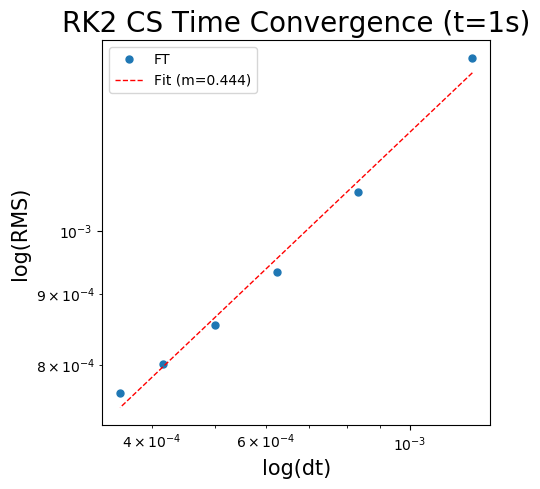

In [145]:
# plot the errors
fig, ax = plt.subplots()
dts = (1-0)/Nts
ax.loglog(dts, t_errors_rk, 'o', label='FT')

# plot the linear fits
log_dts = np.log10(dts)
rk_params = np.polyfit(log_dts[:], np.log10(t_errors_rk)[:], 1)
ax.loglog(dts,10**rk_params[1] * dts**rk_params[0], 'r--', label='Fit (m=%.3f)'%rk_params[0])

ax.set(title='RK2 CS Time Convergence (t=1s)', xlabel='log(dt)', ylabel='log(RMS)')
ax.legend()
plt.show()

Though there is clearly some convergence occurring it is far from the expected 2nd order method. It is clear that a bug is present, though the error orders are small so on a large scale one would guess this solver was working. Though this is unfortunate in review of my code, it a good example of MMS revealing a bug that would have otherwise been missed.

Due to time restrictions I can't fully fix this method. Instead I will just do spacial convergence for FCTS instead. As 2nd order error is expected in space and 1st order in time a very small dt and relatively large dx is needed to ensure space is dominating the error to be observed. This is why RK2 would have been the better time method if I managed to fix it.

dt =  0.0001 
dx =  0.3141592653589793
Progress |##################################################|
Final state reached


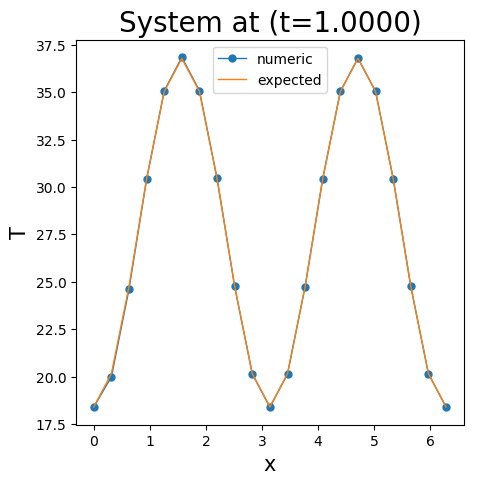

error= 0.05193971915042309 

dt =  0.0001 
dx =  0.2243994752564138
Progress |##################################################|
Final state reached


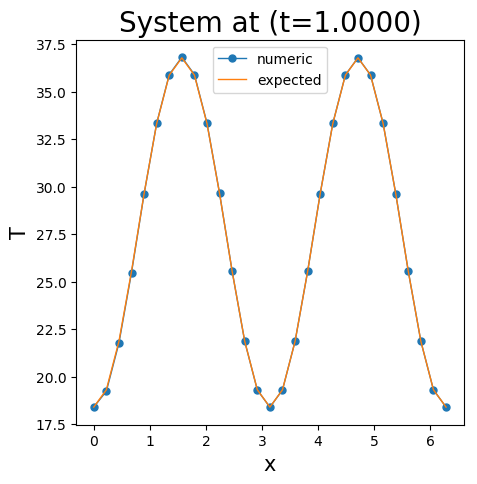

error= 0.026910625412286573 

dt =  0.0001 
dx =  0.16110731556870733
Progress |##################################################|
Final state reached


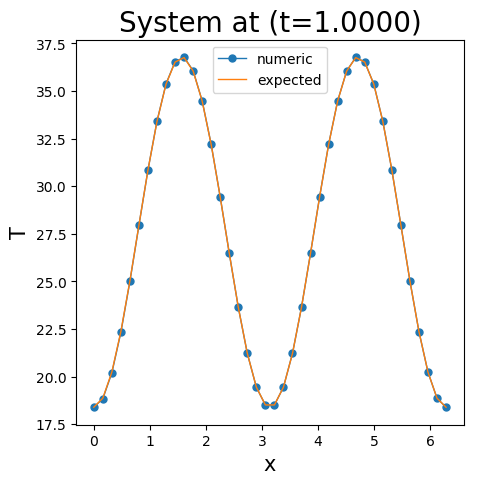

error= 0.014090977903727703 

dt =  0.0001 
dx =  0.11635528346628864
Progress |##################################################|
Final state reached


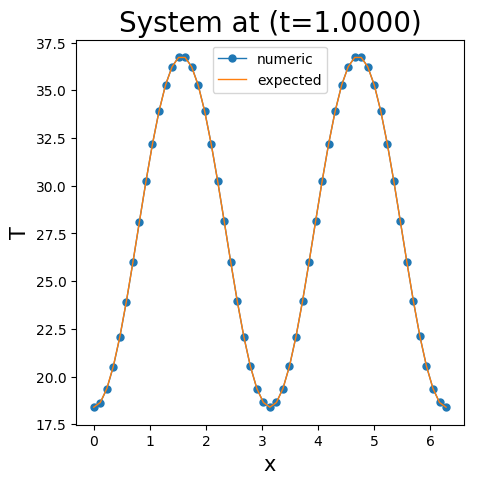

error= 0.007669911804227987 

dt =  0.0001 
dx =  0.08267349088394192
Progress |##################################################|
Final state reached


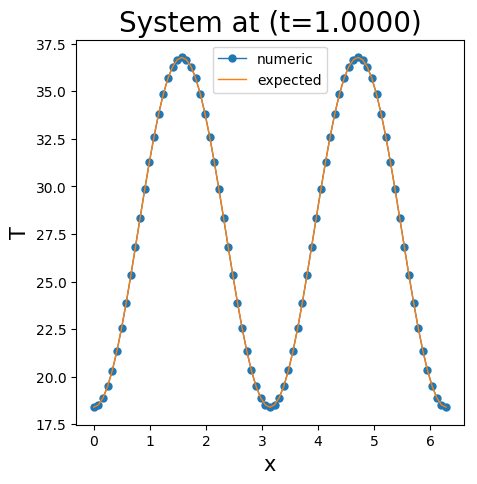

error= 0.004487034363875191 

dt =  0.0001 
dx =  0.05872135801102417
Progress |##################################################|
Final state reached


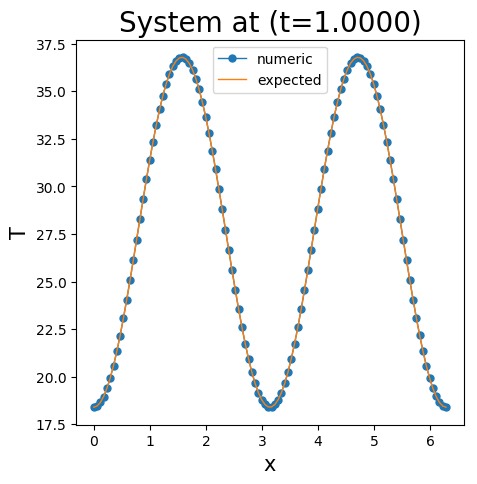

error= 0.003245107095322577 

dt =  0.0001 
dx =  0.041887902047863905
Progress |##################################################|
Final state reached


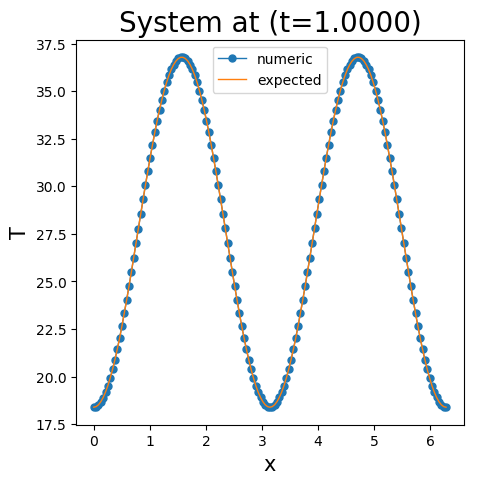

error= 0.0028741397263585705 

dt =  0.0001 
dx =  0.029919930034188507
Progress |##################################################|
Final state reached


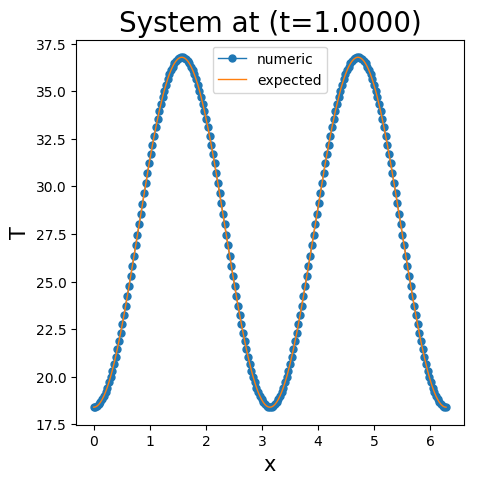

error= 0.0027859165498658393 

dt =  0.0001 
dx =  0.021298933244676563
Progress |##################################################|
Final state reached


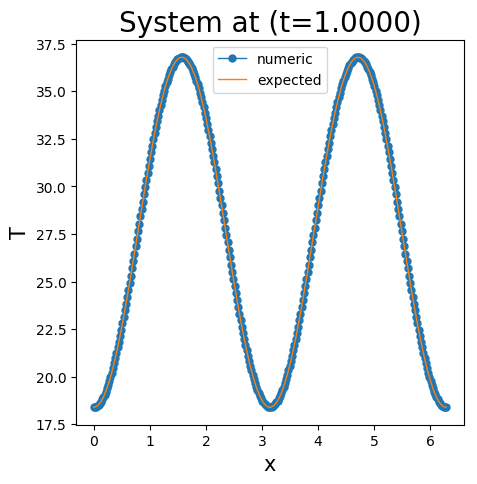

error= 0.0027709809660358842 

dt =  0.0001 
dx =  0.015213523746197546
Progress |##################################################|
Final state reached


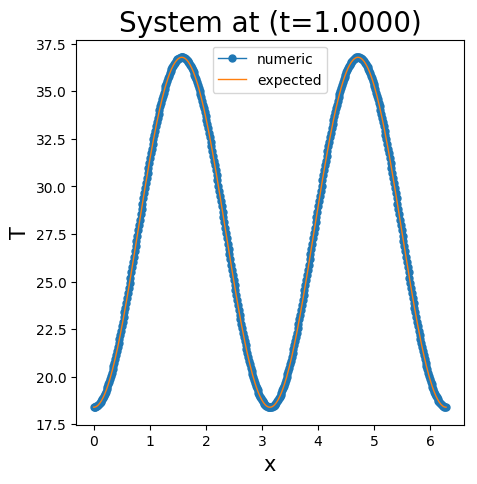

error= 0.0027717596111446106 



In [114]:
# space convergence FT
Nxs = np.array([20 * 1.4**n for n in range(0, 10)]).astype(int)
errors_ft = np.empty(Nxs.size)

for i,Nx in enumerate(Nxs):
    system_ft = heat_solver([0., 1.], [0., 2*np.pi], 10000, Nx)
    system_ft.create_functions(50, 0.2, 1, 1.25, 1)
    
    system_ft.solve(save_int=None, method='FT')
    errors_ft[i] = system_ft.error()
    system_ft.plot(exact=True)  # plot result to see any key errors
    print('error=', system_ft.error(), '\n')

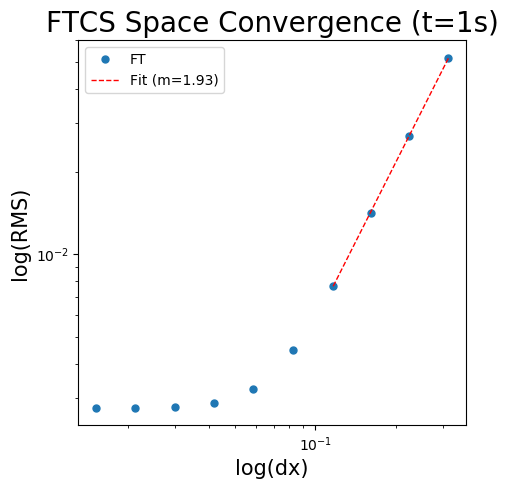

In [139]:
# plot the errors
fig, ax = plt.subplots()
dxs = (2*np.pi)/Nxs
ax.loglog(dxs, errors_ft, 'o', label='FT')

# plot the linear fits
log_dxs = np.log10(dxs)
ft_params = np.polyfit(log_dxs[:4], np.log10(errors_ft)[:4], 1)
ax.loglog(dxs[:4], 10**ft_params[1] * dxs[:4]**ft_params[0], 'r--', label='Fit (m=%.2f)'%ft_params[0])

ax.set(title='FTCS Space Convergence (t=1s)', xlabel='log(dx)', ylabel='log(RMS)')
ax.legend()
plt.show()

Due to the high time resolution this took quite a while to run ($\sim 10mins$). For $dx<10^{-1}$ the time error begins to dominate again, hence the error plateaus and has been excluded from the linear plot. The gradient is $\mathcal{O}(dx) \sim 2$ as expected from a central scheme, though is slightly worse. A reasonable explanation is the relatively large dx values needed to be used mean higher order error terms are significant enough to decrease the overall error order. Alternatively this could be a bug small enough to not remove convergence altogether (such as the previously mentioned bug in the steady state) or some kind inefficiency in the way the code is implemented (for example a magnified round off error).

Since the two convergence plots being of expected order to this complex MMS solution, it seems reasonable to conclude overall that the FTCS solver I have written is verified.